In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from model_pipeline import *
from sklearn.model_selection import train_test_split, KFold, cross_validate
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.decomposition import TruncatedSVD
from scipy import stats

In [2]:
def split_train_test(data, test_ratio, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [3]:
def get_results(y_test, y_proba, thresholds):
    results = pd.DataFrame()
    for ti in thresholds:
        y_adj = (y_proba >= ti).astype(int)
        cm = confusion_matrix(y_test, y_adj)
        tn, fp, fn, tp = cm.ravel()
        
        results[f'thresh={ti}'] = [
            accuracy_score(y_test, y_adj),
            recall_score(y_test, y_adj),
            fp / (fp + tn),
            precision_score(y_test, y_adj),
            tn / (fp + tn),
            f1_score(y_test, y_adj),
        ]
    results.index = ['Accuracy', 'Recall/Sensitivity', 'False Positive Rate', 'Precision', 'Specificity', 'F1 Score']
    
    return results
    
    
    
    

In [7]:
def get_roc_graph(y_test, y_proba, save_fig=None):
    fpr, tpr, thresh = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(fpr, tpr, label=f"AUC={np.round(auc, 2)}")
    ax.set_title('ROC Curve', fontsize=18)
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.legend()
    plt.show()
    
    if save_fig is not None:
        fig.savefig(save_fig)

In [ ]:
def get_roc_graph(y_test, y_proba, save_fig=None):
    fpr, tpr, thresh = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    fig, ax = plt.subplots(figsize=(8,4))
    
    ax.plot(fpr, tpr, label=f"AUC={np.round(auc, 2)}")
    ax.set_title('ROC Curve', fontsize=18)
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.legend()
    plt.show()
    
    if save_fig is not None:
        fig.savefig(save_fig)

In [37]:
a = 'a'
if not isinstance(a, list):
    print('not list')
else:
    print('list')

not list


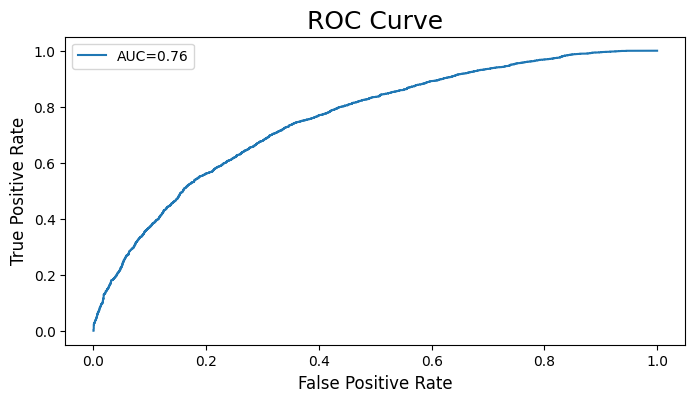

In [31]:
get_roc_graph(y_test, rf_proba, save_fig='roc_rf.png')

In [5]:
def cm_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)
    cm.columns = pd.MultiIndex.from_product([['Predicted'], cm.columns])
    cm = cm.set_index(pd.MultiIndex.from_product([['Actual'], cm.index]))
    return cm

In [6]:
def cross_validation(base_estimator, X, y, threshold, n_fits, test_size=0.2):
    accuracies = np.zeros(n_fits)
    precisions = np.zeros(n_fits)
    recalls = np.zeros(n_fits)
    f1_scores = np.zeros(n_fits)
    fprs = np.zeros(n_fits)
    specificities = np.zeros(n_fits)
    for fiti in range(n_fits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)
        model = base_estimator
        model.fit(X_train, y_train)
        y_pred = (model.predict_proba(X_test)[:,1] > threshold).astype(int)
        
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        accuracies[fiti] = accuracy_score(y_test, y_pred)
        precisions[fiti] = precision_score(y_test, y_pred)
        recalls[fiti] = recall_score(y_test, y_pred)
        f1_scores[fiti] = f1_score(y_test, y_pred)
        fprs[fiti] = fp / (fp + tn)
        specificities[fiti] = tn / (fp + tn)
        
        
    return accuracies, precisions, recalls, f1_scores, fprs, specificities
        

In [8]:
def plot_results(accuracies, precisions, recalls, f1_scores, fprs, specificities, save_fig=None):
    fig, ax = plt.subplots(2,3,figsize=(15,6))
    labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'False Positive Rate', 'Specificity']
    for labeli, vali, axi in zip(labels, [accuracies, precisions, recalls, f1_scores, fprs, specificities], ax.ravel()):
        mean = np.round(np.mean(vali), 2)
        std = np.std(vali, ddof=1)
        n = len(vali)
        ci = [mean - stats.norm.ppf(0.975)* (std / np.sqrt(n)), mean + stats.norm.ppf(0.975)* (std / np.sqrt(n))]
        sns.histplot(vali, kde=True, ax=axi)
        axi.plot([mean,mean], axi.get_ylim(), linestyle='--', label=f"Mean={mean}", color='#EB7620')
        axi.fill_betweenx(axi.get_ylim(), ci[0], ci[1], alpha=0.3, color='#EB7620', label=f"CI= [{np.round(ci[0],4)},{np.round(ci[1],4)}]")
        axi.set_title(labeli, fontsize=14)
        axi.legend()
    fig.tight_layout()
    if save_fig is not None:
        fig.savefig(save_fig)
    plt.show()

In [9]:
df = pd.read_json('transactions.txt', lines=True)
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [10]:
ros = RandomUnderSampler()
X, y = ros.fit_resample(df.drop(columns=['isFraud']), df['isFraud'])
df2 = pd.concat([X, y], axis=1)

In [11]:
r = pd.concat([df.isFraud.value_counts(), df2.isFraud.value_counts()], keys=['Original', 'Under-Sampled'], axis=1)
r

,Original,Under-Sampled
isFraud,,
False,773946,12417
True,12417,12417


In [12]:
train_set, validation_set = split_train_test(df2, 0.2, random_state=1)
print(len(train_set))
print(len(validation_set))

19868
4966


In [12]:
X, y = train_set.drop('isFraud', axis=1), train_set['isFraud']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [14]:
print(X_train.shape)
print(X_test.shape)

(17383, 269)
(7451, 269)


In [15]:
with open('logistic_regression.pkl', 'rb') as f:
    log_reg = pickle.load(f)

In [16]:
lr_params = pd.DataFrame(log_reg.get_params(), index=['value']).T.reset_index()
lr_params.rename(columns={'index':'param'})

,param,value
0,C,0.5
1,class_weight,None
2,dual,False
3,fit_intercept,True
4,intercept_scaling,1
5,l1_ratio,None
6,max_iter,500
7,multi_class,auto
8,n_jobs,None
9,penalty,l1


In [17]:
log_reg.fit(X_train, y_train)
lr_pred = log_reg.predict(X_test)
lr_proba = log_reg.predict_proba(X_test)[:,1]

/home/georgetz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
pd.DataFrame([accuracy_score(y_test, lr_pred), precision_score(y_test, lr_pred), recall_score(y_test, lr_pred)], index=['Accuracy', 'Precision', 'Recall'], columns=['Linear Regression'])

,Linear Regression
Accuracy,0.701896
Precision,0.691233
Recall,0.729956


In [19]:
get_results(y_test, lr_proba, [0.3,0.35,0.4,0.45,0.5,0.55,0.6])

,thresh=0.3,thresh=0.35,thresh=0.4,thresh=0.45,thresh=0.5,thresh=0.55,thresh=0.6
Accuracy,0.649052,0.670022,0.687133,0.696360,0.701896,0.701392,0.684784
Recall/Sensitivity,0.934921,0.893324,0.846360,0.792687,0.729956,0.651459,0.548138
False Positive Rate,0.636913,0.553356,0.472148,0.400000,0.326174,0.248658,0.178523
Precision,0.594877,0.617579,0.641985,0.664698,0.691233,0.723817,0.754386
Specificity,0.363087,0.446644,0.527852,0.600000,0.673826,0.751342,0.821477
F1 Score,0.727107,0.730289,0.730140,0.723072,0.710067,0.685734,0.634933


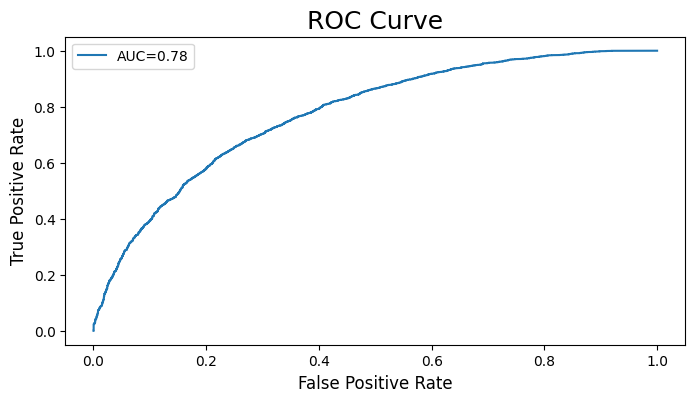

In [20]:
get_roc_graph(y_test, lr_proba, save_fig='roc_lr.png')

In [21]:
lr_adj = (lr_proba >= 0.45).astype(int)
lr_adj

array([1, 1, 1, ..., 1, 1, 1])

In [22]:
cm_plot(y_test, lr_adj)

Predicted      
                 0     1
Actual 0      1788  1192
       1       618  2363

In [23]:
print(cm_plot(y_test, lr_adj).to_latex())

\begin{tabular}{llrr}
\toprule
 &  & \multicolumn{2}{r}{Predicted} \\
 &  & 0 & 1 \\
\midrule
\multirow[t]{2}{*}{Actual} & 0 & 1788 & 1192 \\
 & 1 & 618 & 2363 \\
\cline{1-4}
\bottomrule
\end{tabular}



In [24]:
get_results(y_test, lr_proba, [0.45])

,thresh=0.45
Accuracy,0.696360
Recall/Sensitivity,0.792687
False Positive Rate,0.400000
Precision,0.664698
Specificity,0.600000
F1 Score,0.723072


In [25]:
accuracies, precisions, recalls, f1_scores, fprs, specificities = cross_validation(log_reg, X, y, 0.45, 50)

/home/georgetz/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These

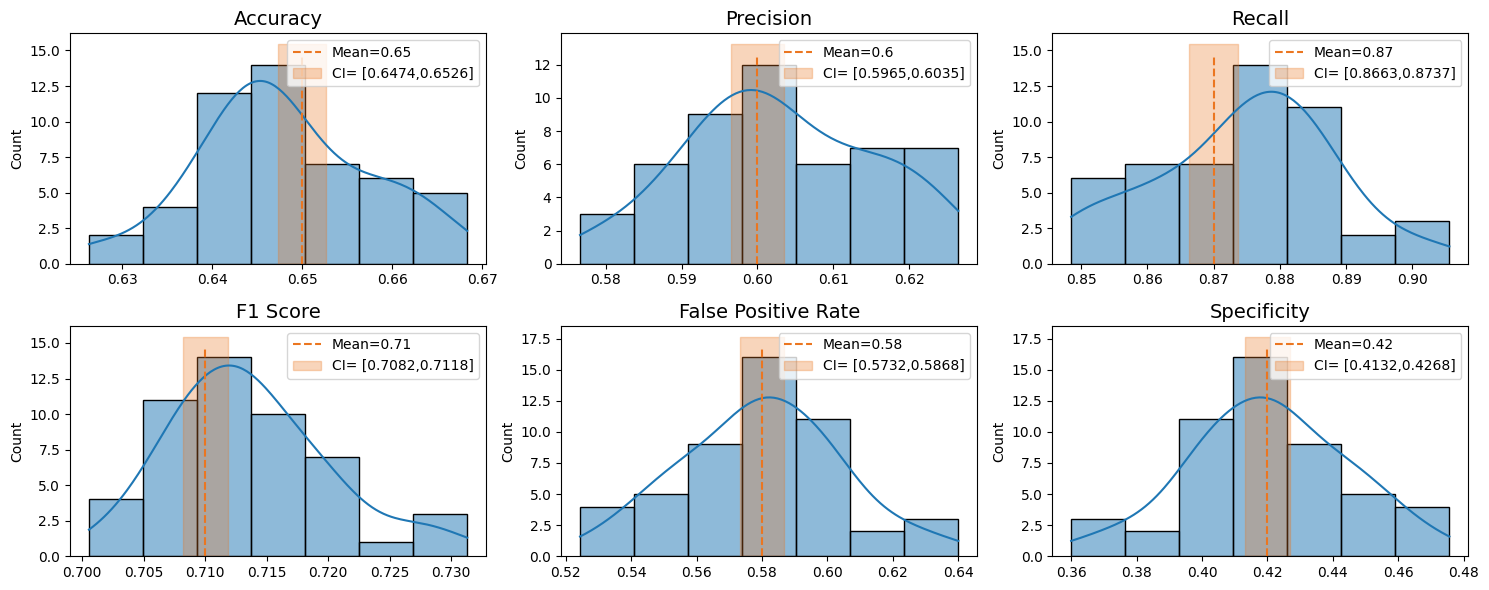

In [100]:
plot_results(accuracies, precisions, recalls, f1_scores, fprs, specificities, save_fig='lr_metrics_graph.png')

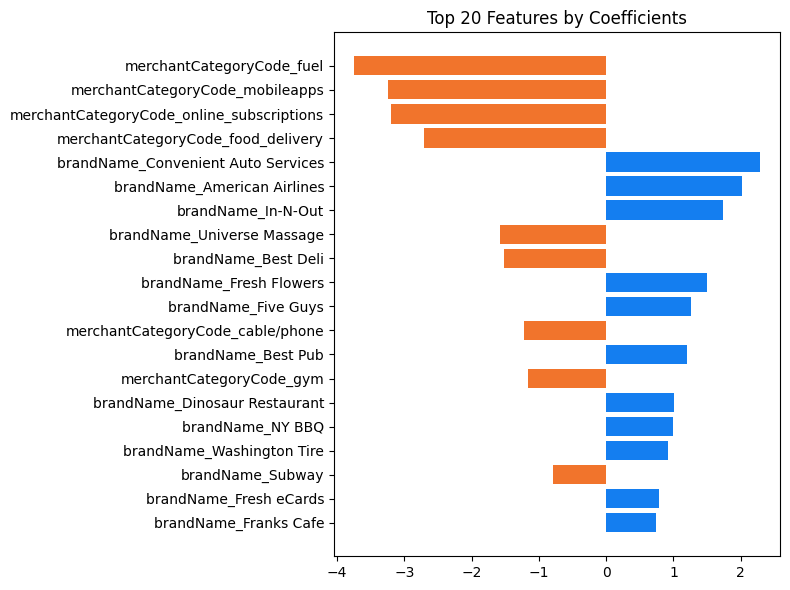

In [19]:
coefficients = log_reg.coef_[0]
sorted_coef_indices = np.argsort(abs(coefficients))[::-1][:20]
sorted_coefficients = coefficients[sorted_coef_indices]

feature_names = np.array(num_cols + list(pipeline.named_steps['col_transformer'].named_transformers_['onehot_encoder'].get_feature_names_out()))[sorted_coef_indices]

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(feature_names[::-1], sorted_coefficients[::-1], color=["#F1742C" if val < 0 else "#147EF0" for val in sorted_coefficients[::-1]])
ax.set_title('Top 20 Features by Coefficients', fontsize=12)
fig.tight_layout()
plt.show()

In [158]:
fig.savefig('lr_feature_importances.png')

[0.03360233215972358,
 0.05460155724814334,
 0.055720860678174264,
 0.11914635665096812,
 7.375886733453561,
 6.806848108279792,
 0.21316183424277316,
 4.625749594994228,
 0.25547050488362294,
 3.710303233650931,
 0.2939194412825281,
 3.018116434448667,
 0.3536026317518678,
 2.7966945207862675,
 2.580495366804404,
 2.40358244926306,
 0.4572886631721026,
 2.1755402867884244,
 0.47843315087430016,
 0.48181682251672264]

In [ ]:
from IPython.display import display

In [20]:
feature_df = pd.DataFrame({'Coef.': sorted_coefficients}, index=feature_names)
feature_df.index.name = 'Feature'
feature_df

,Coef.
Feature,
merchantCategoryCode_fuel,-3.744995
merchantCategoryCode_mobileapps,-3.234597
merchantCategoryCode_online_subscriptions,-3.190570
merchantCategoryCode_food_delivery,-2.704374
brandName_Convenient Auto Services,2.282872
brandName_American Airlines,2.012787
brandName_In-N-Out,1.737320
brandName_Universe Massage,-1.582159
brandName_Best Deli,-1.511066


In [21]:
print(feature_df.to_latex().replace('_', '\_').replace('tabular', 'tabu'))

\begin{tabu}{lr}
\toprule
 & Coef. \\
Feature &  \\
\midrule
merchantCategoryCode\_fuel & -3.744995 \\
merchantCategoryCode\_mobileapps & -3.234597 \\
merchantCategoryCode\_online\_subscriptions & -3.190570 \\
merchantCategoryCode\_food\_delivery & -2.704374 \\
brandName\_Convenient Auto Services & 2.282872 \\
brandName\_American Airlines & 2.012787 \\
brandName\_In-N-Out & 1.737320 \\
brandName\_Universe Massage & -1.582159 \\
brandName\_Best Deli & -1.511066 \\
brandName\_Fresh Flowers & 1.497367 \\
brandName\_Five Guys & 1.255011 \\
merchantCategoryCode\_cable/phone & -1.217289 \\
brandName\_Best Pub & 1.206026 \\
merchantCategoryCode\_gym & -1.165085 \\
brandName\_Dinosaur Restaurant & 1.001877 \\
brandName\_NY BBQ & 0.988073 \\
brandName\_Washington Tire & 0.926045 \\
brandName\_Subway & -0.793096 \\
brandName\_Fresh eCards & 0.778761 \\
brandName\_Franks Cafe & 0.745375 \\
\bottomrule
\end{tabu}



In [106]:
fig.savefig('lr_feature_importances.png')

In [22]:
with open('random_forest.pkl', 'rb') as f:
    rf = pickle.load(f)

In [23]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]

/home/georgetz/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [48]:
get_results(y_test, rf_proba, [0.3,0.35,0.4,0.45,0.5,0.55,0.6])

,thresh=0.3,thresh=0.35,thresh=0.4,thresh=0.45,thresh=0.5,thresh=0.55,thresh=0.6
Accuracy,0.511324,0.526589,0.568697,0.655762,0.692669,0.664318,0.581614
Recall/Sensitivity,1.000000,0.999665,0.977524,0.882590,0.717209,0.463938,0.200604
False Positive Rate,0.977517,0.946644,0.840268,0.571141,0.331879,0.135235,0.037248
Precision,0.505769,0.513705,0.537837,0.607201,0.683722,0.774356,0.843441
Specificity,0.022483,0.053356,0.159732,0.428859,0.668121,0.864765,0.962752
F1 Score,0.671775,0.678661,0.693892,0.719442,0.700065,0.580239,0.324119


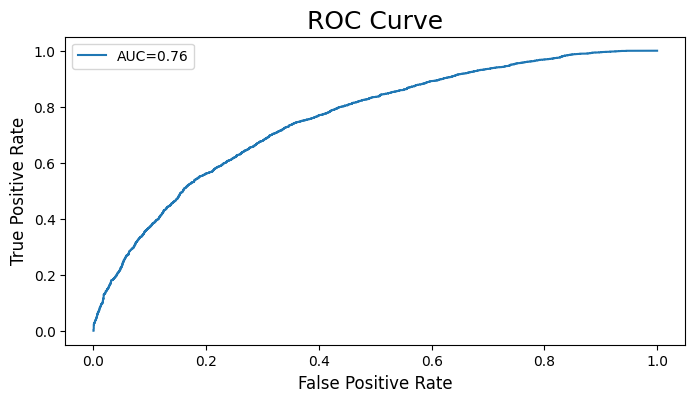

In [26]:
get_roc_graph(y_test, rf_proba, save_fig='roc_rf.png')

In [50]:
rf_adj = (rf_proba > 0.50).astype(int)
rf_adj

array([1, 1, 1, ..., 1, 1, 1])

In [51]:
cm_plot(y_test, rf_adj)

Predicted      
                 0     1
Actual 0      1991   989
       1       843  2138

In [52]:
print(cm_plot(y_test, rf_adj).to_latex())

\begin{tabular}{llrr}
\toprule
 &  & \multicolumn{2}{r}{Predicted} \\
 &  & 0 & 1 \\
\midrule
\multirow[t]{2}{*}{Actual} & 0 & 1991 & 989 \\
 & 1 & 843 & 2138 \\
\cline{1-4}
\bottomrule
\end{tabular}



In [53]:
get_results(y_test, rf_proba, [0.50])

,thresh=0.5
Accuracy,0.692669
Recall/Sensitivity,0.717209
False Positive Rate,0.331879
Precision,0.683722
Specificity,0.668121
F1 Score,0.700065


In [54]:
print(get_results(y_test, rf_proba, [0.50]).to_latex())

\begin{tabular}{lr}
\toprule
 & thresh=0.5 \\
\midrule
Accuracy & 0.692669 \\
Recall/Sensitivity & 0.717209 \\
False Positive Rate & 0.331879 \\
Precision & 0.683722 \\
Specificity & 0.668121 \\
F1 Score & 0.700065 \\
\bottomrule
\end{tabular}



In [116]:
accuracies, precisions, recalls, f1_scores, fprs, specificities = cross_validation(rf, X, y, 0.5, 50)

/home/georgetz/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also t

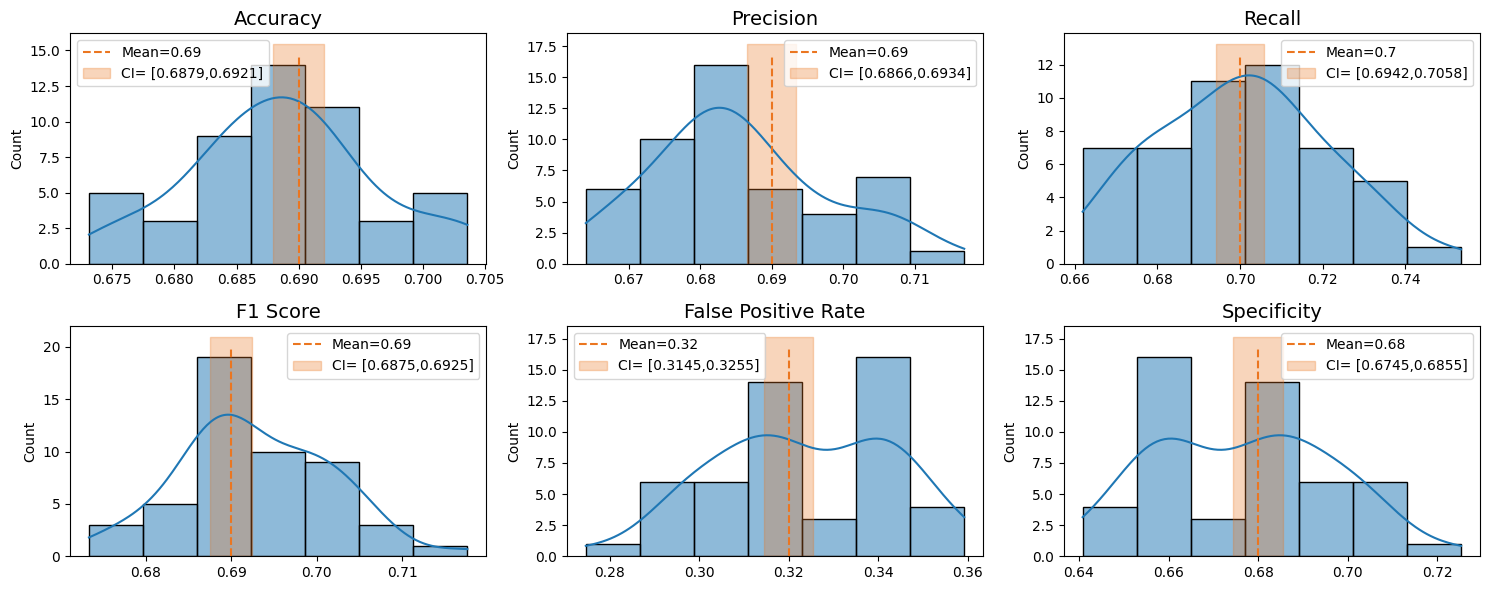

In [117]:
plot_results(accuracies, precisions, recalls, f1_scores, fprs, specificities, save_fig='rf_metrics_graph.png')

In [57]:
rf.feature_importances_

array([4.67927385e-03, 6.78847553e-03, 1.64092445e-01, 1.19470037e-02,
       1.25326913e-02, 9.44913406e-03, 9.57522725e-03, 8.41423202e-02,
       0.00000000e+00, 2.43497688e-03, 7.94806735e-03, 6.89373111e-03,
       1.40604190e-03, 1.78813264e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.41186851e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.27244956e-02,
       0.00000000e+00, 2.07158775e-02, 0.00000000e+00, 1.40495978e-02,
       2.47550407e-05, 0.00000000e+00, 8.15357719e-04, 0.00000000e+00,
       0.00000000e+00, 1.81811825e-04, 0.00000000e+00, 0.00000000e+00,
       2.27304028e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.16798645e-05, 8.62403393e-05, 0.00000000e+00,
       0.00000000e+00, 4.90307617e-04, 2.32514415e-04, 0.00000000e+00,
       7.06540660e-05, 1.00024488e-04, 0.00000000e+00, 0.00000000e+00,
      

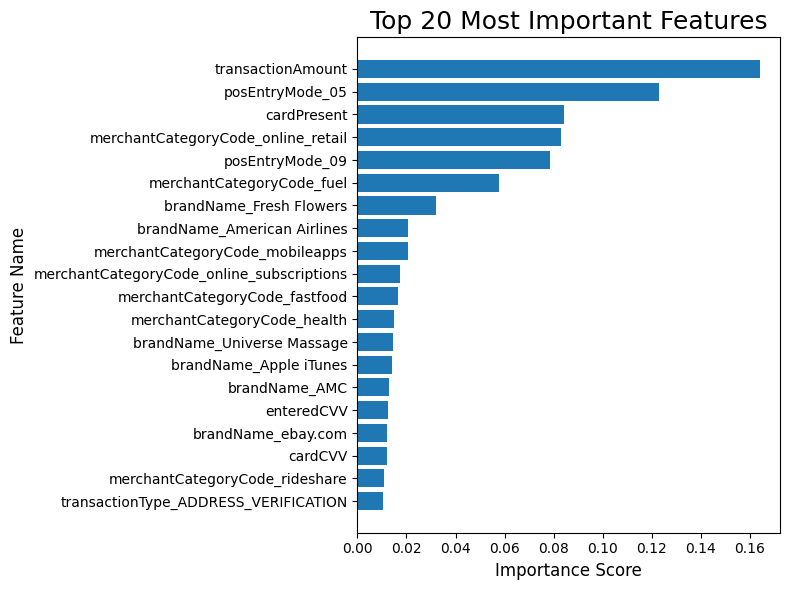

In [180]:
importances = rf.feature_importances_

sorted_indices = np.argsort(importances)[::-1][:20]
sorted_importances = importances[sorted_indices]

feature_names = np.array(num_cols + list(pipeline.named_steps['col_transformer'].named_transformers_['onehot_encoder'].get_feature_names_out()))[sorted_indices]

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(feature_names[::-1], sorted_importances[::-1])
ax.set_title('Top 20 Most Important Features', fontsize=18)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Feature Name', fontsize=12)
fig.tight_layout()
plt.show()

In [101]:
fig.savefig('rf_importance_scores.png')

In [181]:
feature_df = pd.DataFrame({'Proportion': sorted_importances}, index=feature_names)
feature_df.index.name = 'Feature'
feature_df

,Proportion
Feature,
transactionAmount,0.164092
posEntryMode_05,0.123055
cardPresent,0.084142
merchantCategoryCode_online_retail,0.082937
posEntryMode_09,0.078340
merchantCategoryCode_fuel,0.057539
brandName_Fresh Flowers,0.032164
brandName_American Airlines,0.020716
merchantCategoryCode_mobileapps,0.020647


In [182]:
print(feature_df.to_latex().replace('_', '\_').replace('tabular', 'tabu'))

\begin{tabu}{lr}
\toprule
 & Proportion \\
Feature &  \\
\midrule
transactionAmount & 0.164092 \\
posEntryMode\_05 & 0.123055 \\
cardPresent & 0.084142 \\
merchantCategoryCode\_online\_retail & 0.082937 \\
posEntryMode\_09 & 0.078340 \\
merchantCategoryCode\_fuel & 0.057539 \\
brandName\_Fresh Flowers & 0.032164 \\
brandName\_American Airlines & 0.020716 \\
merchantCategoryCode\_mobileapps & 0.020647 \\
merchantCategoryCode\_online\_subscriptions & 0.017387 \\
merchantCategoryCode\_fastfood & 0.016681 \\
merchantCategoryCode\_health & 0.014733 \\
brandName\_Universe Massage & 0.014493 \\
brandName\_Apple iTunes & 0.014050 \\
brandName\_AMC & 0.012724 \\
enteredCVV & 0.012533 \\
brandName\_ebay.com & 0.012169 \\
cardCVV & 0.011947 \\
merchantCategoryCode\_rideshare & 0.010692 \\
transactionType\_ADDRESS\_VERIFICATION & 0.010458 \\
\bottomrule
\end{tabu}



In [27]:
get_results(y_test, lr_proba, [0.45])

,thresh=0.45
Accuracy,0.691585
Recall/Sensitivity,0.786623
False Positive Rate,0.401809
Precision,0.657984
Specificity,0.598191
F1 Score,0.716576


In [28]:
get_results(y_test, rf_proba, [0.50])

,thresh=0.5
Accuracy,0.691048
Recall/Sensitivity,0.715137
False Positive Rate,0.332624
Precision,0.678746
Specificity,0.667376
F1 Score,0.696466


In [43]:
comp_df = pd.concat([get_results(y_test, lr_proba, [0.45]), get_results(y_test, rf_proba, [0.50])], axis=1)
comp_df.rename(columns={'thresh=0.45': 'Logistic Regression (thresh=0.45)', 'thresh=0.5': 'Random Forest (thresh=0.5)'}, inplace=True)
comp_df

,Logistic Regression (thresh=0.45),Random Forest (thresh=0.5)
Accuracy,0.691585,0.691048
Recall/Sensitivity,0.786623,0.715137
False Positive Rate,0.401809,0.332624
Precision,0.657984,0.678746
Specificity,0.598191,0.667376
F1 Score,0.716576,0.696466


In [44]:
print(comp_df.to_latex().replace('tabular', 'tabu'))

\begin{tabu}{lrr}
\toprule
 & Logistic Regression (thresh=0.45) & Random Forest (thresh=0.5) \\
\midrule
Accuracy & 0.691585 & 0.691048 \\
Recall/Sensitivity & 0.786623 & 0.715137 \\
False Positive Rate & 0.401809 & 0.332624 \\
Precision & 0.657984 & 0.678746 \\
Specificity & 0.598191 & 0.667376 \\
F1 Score & 0.716576 & 0.696466 \\
\bottomrule
\end{tabu}



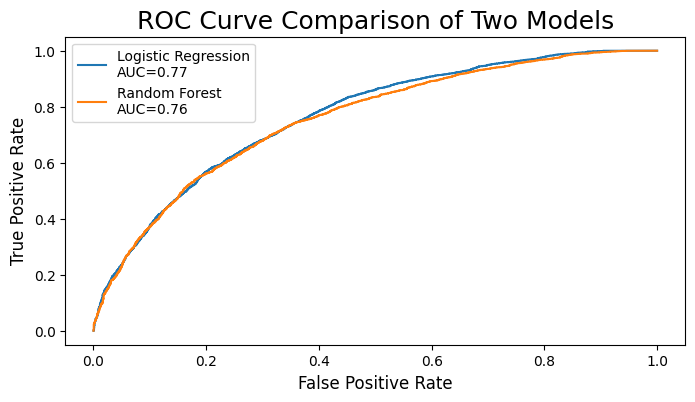

In [40]:
lr_fpr, lr_tpr, lr_thresh = roc_curve(y_test, lr_proba)
lr_auc = roc_auc_score(y_test, lr_proba)

rf_fpr, rf_tpr, rf_thresh = roc_curve(y_test, rf_proba)
rf_auc = roc_auc_score(y_test, rf_proba)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(lr_fpr, lr_tpr, label=f"Logistic Regression\nAUC={np.round(lr_auc, 2)}")
ax.plot(rf_fpr, rf_tpr, label=f"Random Forest\nAUC={np.round(rf_auc, 2)}")
ax.set_title('ROC Curve Comparison of Two Models', fontsize=18)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend()
plt.show()

In [41]:
fig.savefig('roc_both_models.png')